In [1]:
%matplotlib inline
from utils import read, createGraph, readExtraInfo, readGenre, readBirthdays, getCharacterAges
from glob import iglob as glob
from os.path import exists, basename
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import numpy as np
import scipy as sp
import warnings
import networkx as nx
import logging
from funcy import walk_values
from scipy import stats
import itertools
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
logging.basicConfig(format = "%(asctime)-15s %(message)s", level = logging.DEBUG)

In [3]:
th = 2
data_dir = "../data/utterances_with_charnames/*"
info_dir = "../data/charandmovie_info/"
birthdays_f = "../data/age/actor_birthdays.txt"

## Read all scripts

In [4]:
birthdays = readBirthdays(birthdays_f)

In [5]:
data = {}
for script in glob(data_dir):
    
    _, char_list, adj = read(script, threshold = th)

    extra_info = info_dir + basename(script)
    if exists(extra_info):
        genders, races, namesids, movieyear = readExtraInfo(extra_info)
        genres = readGenre(extra_info)
    else:
#         logging.warning("Info for {} not found".format(basename(script)))
#         gens = defaultdict(lambda: 'unknown')
#         races = defaultdict(lambda: 'unknown')  
        continue
    
    def splitRaces(x):
        r = x.split(",")
        if len(r) > 0:
            if len(r) > 1:
                return "mixed"
            else:
                return r[0]
    
    races = walk_values(splitRaces, races)
    ages = getCharacterAges(char_list, namesids, movieyear, birthdays)
        
        
    G = createGraph(char_list,
                    adj,
                    genders = genders,
                    races = races,
                    ages = ages)

    

    key = basename(script)

    data[key] = {}
    data[key]['graph'] = G
    data[key]['chars'] = char_list
    data[key]['genres'] = genres
    data[key]['ages'] = ages
    data[key]['races'] = races
    data[key]['year'] = movieyear
    

In [6]:
data['american_beauty.txt'];

In [7]:
np.sum([nx.number_of_nodes(d['graph']) for d in data.values()])

15133

In [8]:
types = Counter([y for x in [d['genres'] for script, d in data.items()] for y in x])
print(types)
types = list(types.keys())

Counter({'Drama': 559, 'Thriller': 368, 'Comedy': 287, 'Action': 252, 'Crime': 242, 'Romance': 194, 'Adventure': 170, 'Sci-Fi': 156, 'Mystery': 145, 'Horror': 116, 'Fantasy': 115, 'Biography': 70, 'Family': 49, 'History': 34, 'War': 34, 'Sport': 32, 'Animation': 32, 'Music': 22, 'Musical': 19, 'Western': 17, 'Film-Noir': 5, 'Short': 5})


In [9]:
races = Counter([y for x in [list(d['races'].values()) for d in data.values()] for y in x])
print(races)
races = list(races.keys())

Counter({'unknown': 7893, 'caucasian': 6887, 'african': 618, 'mixed': 449, 'latino': 165, 'eastasian': 78, 'asianindian': 44, 'other': 25, 'nativeamerican': 15, 'pacificislander': 7, 'others': 2})


In [39]:
centrality_measures = ['degree_cent', 'betweenness_cent', 'closeness_cent', 'pagerank_cent']

In [10]:
xkcd_colors = sns.xkcd_palette(["grass green", "sand", "blue", "light red", "cerulean",
                                "red", "light blue", "teal", "orange", "light green",
                                "magenta", "yellow", "sky blue", "grey", "cobalt",
                                "grass", "algae green", "coral", "cerise", "steel",
                                "hot purple", "mango", "pale lime", "rouge"])
colors = itertools.cycle(xkcd_colors)

# Pre-check
In [GENDER BIAS WITHOUT BORDERS](http://seejane.org/wp-content/uploads/gender-bias-without-borders-executive-summary.pdf), there is a ratio of 2.25 men for every women on screen (women = $30.9$%). Lets check our numbers.

In [11]:
total, males, females = 0, 0, 0
for _, d in data.items():
    G = d['graph']
    
    for i in G.nodes():
        if G.node[i]['gender'] == 'male':
            males += 1
        elif G.node[i]['gender'] == 'female':
            females += 1
        
        total += 1
        
print("total: {}".format(total))
print("males: {:.2f}%".format(float(males) / total))
print("females: {:.2f}%".format(float(females) / total))


total: 15133
males: 0.55%
females: 0.21%


What if we drop unknown?... shouldn't matter right?

In [12]:
print("males: {:.2f}%".format(float(males) / (males + females)))
print("females: {:.2f}%".format(float(females) / (males + females)))

males: 0.72%
females: 0.28%


# Graph analysis

## Centrality Measurements

### Calculate and save centralities

In [26]:
for script, d in data.items():
    G = d['graph']
    
    degree = nx.degree_centrality(G)
    nx.set_node_attributes(G, 'degree_cent', degree)
    
    betweenness = nx.betweenness_centrality(G)
    nx.set_node_attributes(G, 'betweenness_cent', betweenness)
    
    #eigen = nx.eigenvector_centrality(G)
    #nx.set_node_attributes(G, 'eigen_cent', eigen)
        
    closeness = nx.closeness_centrality(G)
    nx.set_node_attributes(G, 'closeness_cent', closeness)
        
    pagerank = nx.pagerank(G)
    nx.set_node_attributes(G, 'pagerank_cent', pagerank)
    
    

### Some examples

Most prominent women / most prominent men

In [29]:
def averageCents(node):
    return np.mean([node['degree_cent'], node['betweenness_cent'], node['closeness_cent'], node['pagerank_cent']])  
    
male_cents, female_cents = [], []
for script, d in data.items():
    G = d['graph']
    char_list = d['chars']
       
    male_cents.extend([(averageCents(G.node[i]), char_list[i], script) for i in G.nodes() if G.node[i]['gender'] == 'male'])
    female_cents.extend([(averageCents(G.node[i]), char_list[i], script) for i in G.nodes() if G.node[i]['gender'] == 'female'])

In [30]:
sorted(male_cents, key=lambda x: x[0], reverse=True)[0:10]

[(0.87162145608110519, 'LT', 'bad_lieutenant.txt'),
 (0.87162145608110519, 'SCOTTIE', 'vertigo.txt'),
 (0.76924099084391862, 'TONY', 'scarface.txt'),
 (0.7583504914299114, 'KIT', 'badlands.txt'),
 (0.7583504914299114, 'ARON', '127_hours.txt'),
 (0.75557364024770701, 'CHUCK', 'cast_away.txt'),
 (0.75092688171410182, 'ALEXANDER', 'the_time_machine.txt'),
 (0.74796299414234346, 'NICHOLAS', 'the_game.txt'),
 (0.74649130757766047, 'STUMP', 'cobb.txt'),
 (0.73237240060039221, 'RODERICK', 'barry_lyndon.txt')]

In [31]:
sorted(female_cents, key=lambda x: x[0], reverse=True)[0:10]

[(0.74573585404146026, 'OLIVE', 'easy_a.txt'),
 (0.73039165623589319, 'CORALINE', 'coraline.txt'),
 (0.68348361272748526, 'DOROTHY', 'wizard_of_oz_the.txt'),
 (0.67818149282150342, 'JOEY', 'hellraiser_3_hell_on_earth.txt'),
 (0.67770537997062208, 'STEPHANIE', 'drag_me_to_hell.txt'),
 (0.67612995476013682, 'KATHY', 'whistleblower_the.txt'),
 (0.67239447542947228, 'FRANCES', 'frances.txt'),
 (0.67226367733629899, 'THE BRIDE', 'kill_bill_volume_1_and_2.txt'),
 (0.66928807937611212, 'SISSY', 'even_cowgirls_get_the_blues.txt'),
 (0.66738762422461217, 'NORMA', 'sunset_blvd..txt')]

## By Gender

In [37]:
tests = {}
for cent in centr_measures:
    
    male_cent, female_cent = [], []
    
    for script, d in data.items():
        G = d['graph']    
        male_cent.extend([G.node[i][cent] for i in G.nodes() if G.node[i]['gender'] == 'male'])
        female_cent.extend([G.node[i][cent] for i in G.nodes() if G.node[i]['gender'] == 'female'])
    
    #Remove nans
    male_cent, female_cent = np.array(male_cent), np.array(female_cent)
    male_cent = male_cent[~np.isnan(male_cent)]
    female_cent = female_cent[~np.isnan(female_cent)]

    tests[cent] = sp.stats.ttest_ind(male_cent, female_cent, equal_var = False) #Welch’s t-test


In [38]:
# Using Benjamin-Hochberg's method
res_2 = sorted(tests.items(), key = lambda x: x[1].pvalue)
m = len(res_2)

i = 1
while i < len(res_2) + 1:
    if res_2[i - 1][1].pvalue > i / m * 0.05:
        break
    i = i + 1
        
res_2[:(i - 1)]

[('betweenness_cent',
  Ttest_indResult(statistic=3.8572208376848756, pvalue=0.00011572014861540153)),
 ('pagerank_cent',
  Ttest_indResult(statistic=-3.1812155459681355, pvalue=0.0014741102505456153))]

### Split by genre

In [61]:
centr_byGenre = []
for script, d in data.items():
    G = d['graph']
    genres = d['genres']
        
    for centr_t in centrality_measures:
        centr_v = nx.get_node_attributes(G, centr_t)
        genders = nx.get_node_attributes(G, 'gender')
        
        for k in genders:
            if k in centr_v:
                centr_byGenre.extend([(t, centr_t, genders[k], centr_v[k]) for t in genres])
            else:
                centr_byGenre.extend([(t, centr_t, genders[k], np.nan) for t in genres])
                
centr_byGenre = pd.DataFrame(centr_byGenre, columns = ["genre", "centrality", "gender", "value"])
centr_byGenre.head()
    

,genre,centrality,gender,value
0,Drama,degree_cent,female,0.230769
1,Mystery,degree_cent,female,0.230769
2,Thriller,degree_cent,female,0.230769
3,Drama,degree_cent,male,0.615385
4,Mystery,degree_cent,male,0.615385


In [62]:
#Drop nan's
centr_byGenre = centr_byGenre[(centr_byGenre.genre!="Documentary")]
centr_byGenre = centr_byGenre[(centr_byGenre.genre!="Short")]
centr_byGenre = centr_byGenre[(centr_byGenre.genre!="Reality-TV")]

centr_byGenre = centr_byGenre[(centr_byGenre.gender!="unknown")]

centr_byGenre = centr_byGenre.dropna()

centr_byGenre.head()

,genre,centrality,gender,value
0,Drama,degree_cent,female,0.230769
1,Mystery,degree_cent,female,0.230769
2,Thriller,degree_cent,female,0.230769
3,Drama,degree_cent,male,0.615385
4,Mystery,degree_cent,male,0.615385


In [63]:
res = centr_byGenre.groupby(["centrality", "genre"]).apply(lambda x: stats.ttest_ind(x.ix[x['gender'] == 'male', 'value'].values,
                                                                     x.ix[x['gender'] == 'female', 'value'].values))

__ There is a real difference in the centrality of characters in: __

In [92]:
# Using Benjamin-Hochberg's method
bygenre = res.unstack(level=0)
for centr_t in centrality_measures:
    
    tmp = zip(bygenre[centr_t].index, bygenre[centr_t].values)
    
    
    
    res_2 = sorted(tmp, key = lambda x: x[1].pvalue)
    m = len(res_2)

    i = 1
    while i < len(res_2) + 1:
        if res_2[i - 1][1].pvalue > i / m * 0.05:
            break
        i = i + 1

    print(centr_t)
    for g, ttest in res_2[:(i - 1)]:
        print(g, ttest)
    print()

degree_cent
Horror Ttest_indResult(statistic=-3.2818519347171673, pvalue=0.0010604448907446699)

betweenness_cent
Horror Ttest_indResult(statistic=-4.4196894732152261, pvalue=1.0762192050839886e-05)
Drama Ttest_indResult(statistic=4.0141115272343946, pvalue=6.0336059004308011e-05)
Comedy Ttest_indResult(statistic=3.5570755832364216, pvalue=0.0003801932560866106)

closeness_cent
Horror Ttest_indResult(statistic=-3.4837010213770698, pvalue=0.00051203560117389418)

pagerank_cent
Horror Ttest_indResult(statistic=-3.7184372138310744, pvalue=0.00020955032684054153)



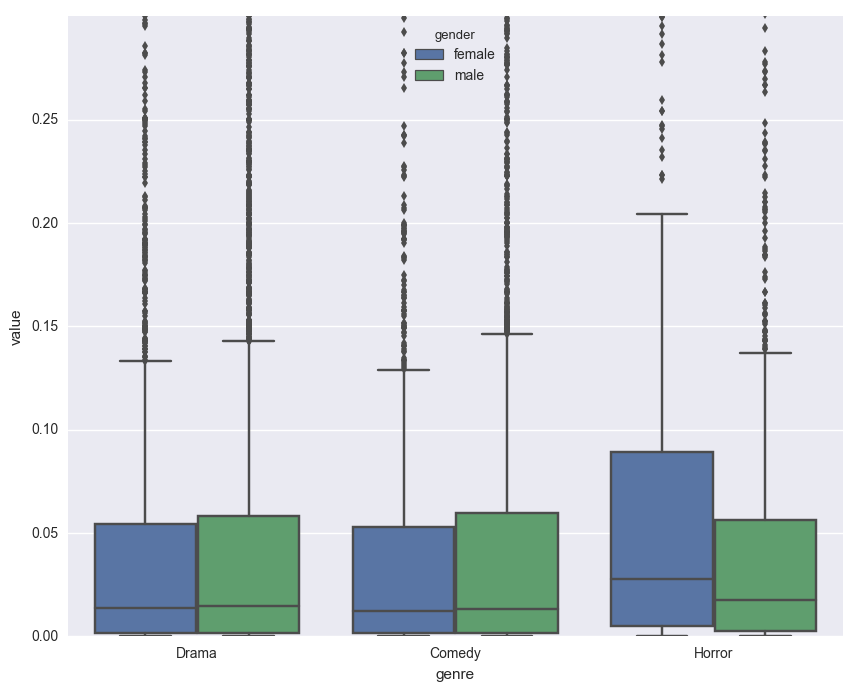

In [102]:
t = centr_byGenre[centr_byGenre.genre.isin(['Drama', 'Comedy', 'Horror'])]
t = t[t.centrality == "betweenness_cent"]
bplt = sns.boxplot(x = 'genre', y = 'value', hue = 'gender', data = t)
bplt.axes.set_ylim([0, .3]);

## By Race
I can either agg by race (e.g., caucassian males get more important roles) or I could agg races by gender (e.g., latino women are more demanded than latino men).

In [108]:
# Agg by race
centr_race_byGenre = []
for script, d in data.items():
    G = d['graph']
    genres = d['genres']
        
    for centr_t in centrality_measures:
        centr_v = nx.get_node_attributes(G, centr_t)
        genders = nx.get_node_attributes(G, 'gender')
        races = nx.get_node_attributes(G, 'race')
        
        for k in genders:
            if k in centr_v:
                centr_race_byGenre.extend([(t, centr_t, genders[k], races[k], centr_v[k]) for t in genres])
            else:
                centr_race_byGenre.extend([(t, centr_t, genders[k], races[k], np.nan) for t in genres])
                
centr_race_byGenre = pd.DataFrame(centr_race_byGenre, columns = ["genre", "centrality", "gender", "race", "value"])
centr_race_byGenre.head()

,genre,centrality,gender,race,value
0,Drama,degree_cent,female,unknown,0.230769
1,Mystery,degree_cent,female,unknown,0.230769
2,Thriller,degree_cent,female,unknown,0.230769
3,Drama,degree_cent,male,caucasian,0.615385
4,Mystery,degree_cent,male,caucasian,0.615385


__ Analysis was moved to R __

In [109]:
# Save to use in R
centr_race_byGenre.to_csv("../data/R/aggByRace.csv")

## By Age

In [ ]:
# WHO THE FUCK HAD >!00 YRS!?
for script, d in data.items():
    G = d['graph']
    char_list = d['chars']
    
    for n in G.nodes():
        if G.node[n]['age'] > 100:
            print(script, char_list[n], G.node[n]['age'])

In [ ]:
# Agg by age

aggByAge = []

for script, d in data.items():
    G = d['graph']
    centrs = nx.betweenness_centrality(G)
    
    
    for n in G.nodes():
        aggByAge.append((G.node[n]['age'], centrs[n]))
        
aggByAge = pd.DataFrame(aggByAge, columns=['age', 'value'])
aggByAge = aggByAge[aggByAge.age > 0]
aggByAge.head()

In [ ]:
# Drop the guy with more than 100 yrs
aggByAge = aggByAge[aggByAge.age < 100]

In [ ]:
stats.describe(aggByAge.age)

In [ ]:
# Make age groups
aggByAge['ageGrp'] = aggByAge.age.apply(lambda x: (x // 15) * 15)
aggByAge.groupby('ageGrp').agg([len, np.mean, np.std])

In [ ]:
ax = sns.regplot(x = "age", y = "value", data = aggByAge, fit_reg = False)

### By Age and Gender

In [ ]:
# Agg by age & gender

aggByAgeGender = []

for script, d in data.items():
    G = d['graph']
    centrs = nx.betweenness_centrality(G)
    
    
    for n in G.nodes():
        aggByAgeGender.append((G.node[n]['age'], G.node[n]['gender'], centrs[n]))
        
aggByAgeGender = pd.DataFrame(aggByAgeGender, columns=['age', 'gender', 'value'])
aggByAgeGender = aggByAgeGender[aggByAgeGender.age > 0]
aggByAgeGender = aggByAgeGender[aggByAgeGender.gender != 'unknown']

aggByAgeGender.head()

In [ ]:
aggByAgeGender.to_csv("../data/R/aggByAgeGender.csv")

In [ ]:
ax = sns.lmplot(x = "age", y = "value", hue = "gender", data = aggByAgeGender, fit_reg = False)

In [ ]:
#sns.boxplot(x = "gender", y = "value", hue = "gender", data = aggByAgeGender);

In [ ]:
ages_women = aggByAgeGender.ix[aggByAgeGender.gender == "female", "age"]
ages_male = aggByAgeGender.ix[aggByAgeGender.gender == "male", "age"]

#Remove nans
male_deg, female_deg = np.array(ages_male), np.array(ages_women)
male_deg = male_deg[~np.isnan(male_deg)]
female_deg = female_deg[~np.isnan(female_deg)]

ttest = sp.stats.ttest_ind(male_deg, female_deg, equal_var = False) #Welch’s t-test
ttest

In [ ]:
# homoscedasticity
# WTF??? Age is continuous 

In [ ]:
#2-way ANOVA for differences

mod = ols('value ~ C(gender) + age + C(gender):age',
                data=aggByAgeGender).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

### Controlling by genre

In [ ]:
res = {}
for t in types:
    male_age, female_age = [], []
    for script, d in data.items():
        
        if t not in d['genres']:
            continue 
            
        G = d['graph']
        #centralities = nx.betweenness_centrality(G)

        male_age.extend([G.node[i]['age'] for i in G.nodes() if G.node[i]['gender'] == 'male'])
        female_age.extend([G.node[i]['age'] for i in G.nodes() if G.node[i]['gender'] == 'female'])
    
    res[t] = {}
    res[t]['male'] = male_age
    res[t]['female'] = female_age

In [ ]:
# Pass into long format
tmp = []
for t, k in res.items():
    for g, v in k.items():
        for i in v:
            tmp.append((t, g, i))

tmp = pd.DataFrame(tmp, columns=["genre", "gender", "age"])

#Drop nan's
tmp = tmp[(tmp.genre!="Documentary")]
tmp = tmp[(tmp.genre!="Short")]
tmp = tmp[(tmp.genre!="Reality-TV")]

# Drop zero age
tmp = tmp[tmp.age > 0]

tmp.head()

In [ ]:
sns.boxplot(x = "genre", y = "age", hue = "gender", data = tmp);

In [ ]:
res = {}
for t in types:
    male_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "male"), "age"]
    female_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "female"), "age"]
    
    #Remove nans
    male_deg, female_deg = np.array(male_deg), np.array(female_deg)
    male_deg = male_deg[~np.isnan(male_deg)]
    female_deg = female_deg[~np.isnan(female_deg)]

    ttest = sp.stats.ttest_ind(male_deg, female_deg, equal_var = False) # Welch’s t-test

    if not np.isnan(ttest.pvalue):
        res[t] = ttest
    
res;

In [ ]:
# Using Benjamin-Hochberg's method
res_2 = sorted(res.items(), key = lambda x: x[1].pvalue)
m = len(res_2)

i = 1
while i < len(res_2) + 1:
    if res_2[i - 1][1].pvalue > i / m * 0.05:
        break
    i = i + 1
        
res_2[:(i - 1)]

In [ ]:
set(types) - set(map(lambda x: x[0], res_2))